# CMIP6

This notebook demonstrates access to **Coupled Model Intercomparison Project Phase** 6 (`CMIP6`) data. Broad information about the dataset can be found on the PACE website (see [here](https://oceandata.sci.gsfc.nasa.gov))

**Requirements to run this notebook**
1. None

**Objectives**
 
Use [pydap](https://pydap.github.io/pydap/)'s client API to demonstrate

- To demonstrate remote access to CMIP data available through the **Earth System Grid Federation [ESGF](https://aims2.llnl.gov/search/cmip6/) Portal.
- To access and subset remote data using the DAP2 Protocol.



The **Earth System Grid Federation** [ESGF](https://aims2.llnl.gov/search/cmip6/) Contains a broad range of model output (e.g, CMIP3, CMIP5, [CMIP6](https://pcmdi.llnl.gov/CMIP6/), E3SM) from which you can obtain OPeNDAP URLs for data variables. To access the ESGF Node and browse data [click here](https://aims2.llnl.gov/search/cmip6/).



`Author`: Miguel Jimenez-Urias, '24

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydap.client import open_url
import cartopy.crs as ccrs

**CMIP6 Access via OPeNDAP server**

You can also directly inspect a THREDDS catalog for [CMIP6](https://crd-esgf-drc.ec.gc.ca/thredds/catalog/esgB_dataroot/AR6/CMIP6/catalog.html). For example, you can navigate to `CDRMIP/CCCma/CanESM5/esm-pi-cdr-pulse/r2i1p2f1/Eday/ts/gn/v20190429` and access [ts data](https://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgB_dataroot/AR6/CMIP6/CDRMIP/CCCma/CanESM5/esm-pi-cdr-pulse/r2i1p2f1/Eday/ts/gn/v20190429/ts_Eday_CanESM5_esm-pi-cdr-pulse_r2i1p2f1_gn_54510101-56501231.nc.html) via OPeNDAP DAP2 protocol.



In [2]:
url = "https://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgB_dataroot/AR6/CMIP6/CDRMIP/CCCma/CanESM5/esm-pi-cdr-pulse/r2i1p2f1/Eday/ts/gn/v20190429/ts_Eday_CanESM5_esm-pi-cdr-pulse_r2i1p2f1_gn_54510101-56501231.nc"

**Create dataset access via pydap**

By default `protocol='dap2'`, however the default behavior may change in the future.


In [3]:
%%time
ds = open_url(url, protocol='dap2', output_grid=True)

CPU times: user 14.2 ms, sys: 4.74 ms, total: 19 ms
Wall time: 477 ms


In [4]:
ds.tree()

.esgB_dataroot/AR6/CMIP6/CDRMIP/CCCma/CanESM5/esm-pi-cdr-pulse/r2i1p2f1/Eday/ts/gn/v20190429/ts_Eday_CanESM5_esm-pi-cdr-pulse_r2i1p2f1_gn_54510101-56501231.nc
├──time
├──time_bnds
├──lat
├──lat_bnds
├──lon
├──lon_bnds
└──ts
   ├──ts
   ├──time
   ├──lat
   └──lon


In [5]:
print('Dataset memory user [GBs, uncompressed]: ', ds.nbytes/1e9)

Dataset memory user [GBs, uncompressed]:  2.394406144


**Inspect single variable**



In [6]:
ts = ds['ts']
ts

<GridType with array 'ts' and maps 'time', 'lat', 'lon'>

**Grid Arrays**

- No longer implemented in `DAP4`. These carry copies of dimensions/coverage, and can be considered self-contained.
- Attempting to download into memory `ts` also downloads `time`, `lat`, `lon`.
- Attributes sit the `GridType` level. For example:

```python
ds['ts'].attributes
```
and
```python
ds['ts']['ts'].attributes
```
yield different results.


In [7]:
def decode(variable) -> np.ndarray:
    """Decodes the variable BaseType according with atributes:
        _FillValue
        scale_factor

    Parameters:
        variable: BaseType (pydap model)
    """
    import pydap
    scale_factor = 1
    _Fillvalue = None

    if 'scale_factor' in variable.attributes:
        scale_factor = variable.scale_factor
    if '_FillValue' in variable.attributes:
        if isinstance(variable, pydap.model.GridType):
            data = np.where(variable.array.data == variable._FillValue, np.nan, variable.array.data) 
        elif isinstance(variable, pydap.model.BaseType):
            data = np.where(variable.data == variable._FillValue, np.nan, variable.data)    
    else:
        data = variable.data
    return scale_factor * data

In [8]:
ts.tree()

.ts
├──ts
├──time
├──lat
└──lon


**Let's make some plots!**

We will pick the Grid type `ts` at `time=0`. Will use `pydap`.


**NOTE**: When making a plot, check for missing values, scale factors, units.


In [9]:
ds['ts'].shape

(73000, 64, 128)

In [10]:
# download the entire GridType, single snapshot
GTS = ds['ts'][0, :, :]
GTS

<GridType with array 'ts' and maps 'time', 'lat', 'lon'>

In [11]:
GTS.attributes

{'standard_name': 'surface_temperature',
 'long_name': 'Surface Temperature',
 'comment': 'Temperature of the lower boundary of the atmosphere',
 'units': 'K',
 'original_name': 'GT',
 'cell_methods': 'area: time: mean',
 'cell_measures': 'area: areacella',
 'history': '2019-08-20T21:03:55Z altered by CMOR: Reordered dimensions, original order: lat lon time. 2019-08-20T21:03:55Z altered by CMOR: replaced missing value flag (1e+38) and corresponding data with standard missing value (1e+20).',
 'missing_value': 1e+20,
 '_FillValue': 1e+20,
 '_ChunkSizes': [1, 64, 128]}

In [12]:
GTS.shape

(1, 64, 128)

In [13]:
len(GTS.data), type(GTS.data)

(4, list)

`NOTE`:
```python
# why is it greater than 1?
len(GTS.data) != 1 
```
this is because downloading the `Grid` array downloads its coordinate dimensions too, resulting in a list of length 4!


## New Default behavior

```{note}
As of version `3.5.4`, the default behavior now is `output_grid=False`, when using `open_url` . This has a very different behavior as with `output_grid=True`
```


In [14]:
%%time
ds = open_url(url, protocol='dap2') # output_grid=False as defaiult

CPU times: user 11.1 ms, sys: 2.93 ms, total: 14.1 ms
Wall time: 391 ms


In [15]:
# download the entire GridType, single snapshot
TS = ds['ts'][0, :, :]
TS

<BaseType with data array([[[248.65997, 248.28497, 248.15997, ..., 249.53497, 249.65997,
         249.15997],
        [251.65997, 250.78497, 250.53497, ..., 252.65997, 252.40997,
         251.65997],
        [251.03497, 250.15997, 249.03497, ..., 255.03497, 253.53497,
         253.03497],
        ...,
        [224.5918 , 224.67487, 225.22243, ..., 226.25885, 225.4502 ,
         224.54295],
        [219.77655, 220.37973, 221.11984, ..., 218.04332, 218.55197,
         219.16682],
        [220.43169, 220.94601, 221.48468, ..., 220.07048, 219.97438,
         220.07361]]], shape=(1, 64, 128), dtype='>f4')>

In [16]:
len(TS.data), type(TS.data)

(1, numpy.ndarray)

`NOTE`:
```python
len(TS.data) == 1 
```
And `TS` is a `BaseType`, this means it did not download coordinate data when slicing the array

```{note}
Since the data is periodic in longitude, we need to append a copy to the array. We need to do this since cartopy interpolates data. If we don't, then there will be missing longitude band of missing data in for plot as shown below:
```

In [17]:
Lon, Lat = np.meshgrid(ds['lon'].data, ds['lat'].data)

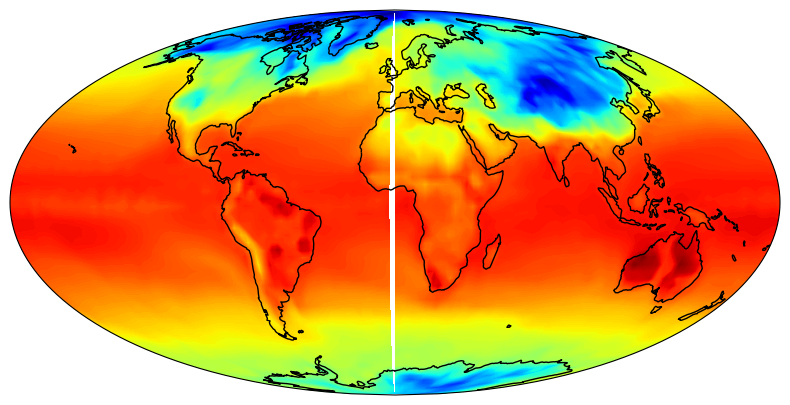

In [18]:
plt.figure(figsize=(15, 5))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()
ax.contourf(Lon, Lat, np.squeeze(decode(GTS)), 200, transform=ccrs.PlateCarree(), cmap='jet')
plt.show()

**Fig 1**. Global Near surface temperature on a (longitude)-periodic domain.